In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_1449224/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-07-03"
ORG_NAME = "Plaza"
SPLITS_FREQ = "3d"
LAST_FOLDS = 20
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-06-29"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 419 non-null    object        
 1   author             419 non-null    object        
 2   date               419 non-null    datetime64[us]
 3   start              419 non-null    datetime64[us]
 4   end                416 non-null    datetime64[us]
 5   platform_proposal  419 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 19.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        534 non-null    object        
 1   proposal  534 non-null    object        
 2   voter     534 non-null    object        
 3   date      534 non-null    datetime64[us]
dtypes: dat

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2023-05-22    531
2023-05-25    531
2023-05-28    531
2023-05-31    531
2023-06-03    531
2023-06-06    531
2023-06-09    531
2023-06-12    531
2023-06-15    531
2023-06-18    531
2023-06-21    531
2023-06-24    532
2023-06-27    532
2023-06-30    532
2023-07-03    532
2023-07-06    532
2023-07-09    532
2023-07-12    532
2023-07-15    532
2023-07-18    532
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2023-W21,0,0,0,nan,nan,0,0,nan,nan
2023-W21,0,0,0,nan,nan,0,0,nan,nan
2023-W21,0,0,0,nan,nan,0,0,nan,nan
2023-W22,0,0,0,nan,nan,0,0,nan,nan
2023-W22,0,0,0,nan,nan,0,0,nan,nan
2023-W23,0,0,0,nan,nan,0,0,nan,nan
2023-W23,0,0,0,nan,nan,0,0,nan,nan
2023-W24,0,0,0,nan,nan,0,0,nan,nan
2023-W24,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2023-W21 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W21 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W21 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W22 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W22 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W23 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W23 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W25 & 1 & 1 & 1 & 1.00 & 1.00 &

## Running openpop baseline

In [9]:
folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)

    mdict = {'t': t}
    pdict = {'t': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)

  0%|          | 0/238 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1


Warning, empty test fold 2


Warning, empty test fold 4
Warning, empty test fold 5


Warning, empty test fold 7
Warning, empty test fold 8


Warning, empty test fold 9


Warning, empty test fold 12


Warning, empty test fold 14


Warning, empty test fold 16
Warning, empty test fold 17


Warning, empty test fold 18
Warning, empty test fold 19


Warning, empty test fold 21
Warning, empty test fold 22


Warning, empty test fold 23


Warning, empty test fold 25
Warning, empty test fold 26


Warning, empty test fold 28


Warning, empty test fold 31


Warning, empty test fold 33


Warning, empty test fold 37
Warning, empty test fold 38


Warning, empty test fold 42


Warning, empty test fold 49


Warning, empty test fold 51


Warning, empty test fold 53
Warning, empty test fold 54


Warning, empty test fold 55
Warning, empty test fold 56


Warning, empty test fold 57
Warning, empty test fold 58


Warning, empty test fold 60
Warning, empty test fold 61


Warning, empty test fold 62
Warning, empty test fold 63


Warning, empty test fold 65


Warning, empty test fold 68


Warning, empty test fold 70


Warning, empty test fold 72
Warning, empty test fold 73


Warning, empty test fold 74


Warning, empty test fold 76


Warning, empty test fold 78
Warning, empty test fold 79


Warning, empty test fold 80
Warning, empty test fold 81


Warning, empty test fold 82
Warning, empty test fold 83


Warning, empty test fold 84


Warning, empty test fold 86


Warning, empty test fold 88


Warning, empty test fold 90


Warning, empty test fold 94
Warning, empty test fold 95


Warning, empty test fold 97


Warning, empty test fold 99


Warning, empty test fold 103


Warning, empty test fold 105
Warning, empty test fold 106


Warning, empty test fold 107


Warning, empty test fold 109
Warning, empty test fold 110


Warning, empty test fold 111
Warning, empty test fold 112


Warning, empty test fold 113


Warning, empty test fold 115
Warning, empty test fold 116


Warning, empty test fold 118


Warning, empty test fold 120
Warning, empty test fold 121


Warning, empty test fold 126
Warning, empty test fold 127


Warning, empty test fold 128


Warning, empty test fold 131
Warning, empty test fold 132


Warning, empty test fold 133


Warning, empty test fold 137
Warning, empty test fold 138


Warning, empty test fold 149
Warning, empty test fold 150


Warning, empty test fold 151
Warning, empty test fold 152


Warning, empty test fold 153
Warning, empty test fold 154


Warning, empty test fold 155


Warning, empty test fold 157
Warning, empty test fold 158


Warning, empty test fold 159
Warning, empty test fold 160


Warning, empty test fold 161
Warning, empty test fold 162


Warning, empty test fold 167
Warning, empty test fold 168


Warning, empty test fold 169
Warning, empty test fold 170


Warning, empty test fold 171
Warning, empty test fold 172


Warning, empty test fold 173
Warning, empty test fold 174


Warning, empty test fold 175
Warning, empty test fold 176


Warning, empty test fold 177
Warning, empty test fold 178


Warning, empty test fold 179
Warning, empty test fold 180


Warning, empty test fold 181
Warning, empty test fold 182


Warning, empty test fold 184


Warning, empty test fold 189


Warning, empty test fold 194
Warning, empty test fold 195


Warning, empty test fold 201
Warning, empty test fold 202


Warning, empty test fold 203
Warning, empty test fold 204


Warning, empty test fold 210
Warning, empty test fold 211


Warning, empty test fold 212
Warning, empty test fold 213


Warning, empty test fold 214
Warning, empty test fold 215


Warning, empty test fold 216
Warning, empty test fold 217


Warning, empty test fold 218
Warning, empty test fold 219


Warning, empty test fold 220
Warning, empty test fold 221


Warning, empty test fold 222
Warning, empty test fold 223


Warning, empty test fold 224
Warning, empty test fold 225


Warning, empty test fold 226
Warning, empty test fold 227


Warning, empty test fold 228
Warning, empty test fold 229


Warning, empty test fold 230
Warning, empty test fold 231


Warning, empty test fold 232


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("t")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Plaza/baseline/openpop_3d_normalize.pq


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,238.000000,238.000000,236.000000,234.000000,234.000000,234.000000,234.000000,238.000000
mean,0.048319,0.034314,0.023389,0.011695,0.007796,0.001169,0.048319,0.047853,0.049811,0.049811,...,0.055322,0.055322,0.055322,0.026050,0.040678,0.042735,0.042735,0.042735,0.042735,0.074562
std,0.212424,0.144808,0.101554,0.050777,0.033851,0.005078,0.212424,0.194738,0.195930,0.195930,...,0.214560,0.214560,0.214560,0.130645,0.179605,0.187412,0.187412,0.187412,0.187412,0.016127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067238
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068362
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069062
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070445
max,1.000000,1.000000,1.000000,0.500000,0.333333,0.050000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.231950


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("t")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Plaza/baseline/perfect_3d_normalize.pq


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,0.411765,0.187908,0.115266,0.058053,0.038702,0.005805,0.411765,0.411765,0.411765,0.411765,...,0.411765,0.411765,0.411765,0.346379,0.408884,0.411164,0.411765,0.411765,0.411765,0.091871
std,0.493190,0.260634,0.166104,0.084773,0.056515,0.008477,0.493190,0.493190,0.493190,0.493190,...,0.493190,0.493190,0.493190,0.444515,0.490758,0.492558,0.493190,0.493190,0.493190,0.023635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070687
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071846
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072856
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.118783
max,1.000000,1.000000,1.000000,0.500000,0.333333,0.050000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127510


## Plotting some graphs

,t,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,238,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,236.000000,234.000000,234.000000,234.000000,234.000000,238.000000,0.0,0.0
mean,2022-07-27 12:00:00,0.048319,0.034314,0.023389,0.011695,0.007796,0.001169,0.048319,0.047853,0.049811,...,0.055322,0.026050,0.040678,0.042735,0.042735,0.042735,0.042735,0.074562,NaN,NaN
min,2021-08-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067238,NaN,NaN
25%,2022-01-30 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068362,NaN,NaN
50%,2022-07-27 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069062,NaN,NaN
75%,2023-01-21 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070445,NaN,NaN
max,2023-07-18 00:00:00,1.000000,1.000000,1.000000,0.500000,0.333333,0.050000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.231950,NaN,NaN
std,NaN,0.212424,0.144808,0.101554,0.050777,0.033851,0.005078,0.212424,0.194738,0.195930,...,0.214560,0.130645,0.179605,0.187412,0.187412,0.187412,0.187412,0.016127,NaN,NaN


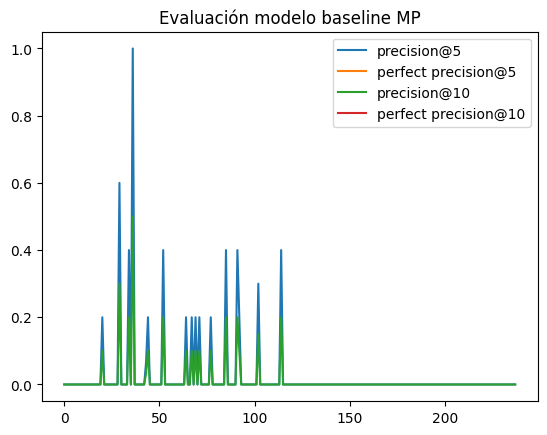

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,t,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,20,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.000000,0.0,0.0
mean,2023-06-19 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069021,NaN,NaN
min,2023-05-22 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067909,NaN,NaN
25%,2023-06-05 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068397,NaN,NaN
50%,2023-06-19 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068863,NaN,NaN
75%,2023-07-03 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069469,NaN,NaN
max,2023-07-18 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070788,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000783,NaN,NaN
